In [1]:

import logging
import warnings
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from analysis import bayescorr, best


In [2]:

warnings.filterwarnings("ignore")

logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

# Random seed
SEED = 32
np.random.seed(SEED)

# MCMC settings (passed on to pm.sample)
sample_kwargs = {"cores": 1, "random_seed": SEED, "progressbar": False}

# Directories
RESULTS_DIR = join("..", "results")
OUTPUT_DIR = join("..", "results", "3-behavioural-modeling")

# Load estimates and BICs
estimates = pd.read_csv(
    join(RESULTS_DIR, "3-behavioural-modeling", "estimates", "estimates_de1.csv")
)

In [4]:
def calc_rst(df, effect="attraction"):
    """Calculate RST.
    
    Parameters
    ----------
    df : pandas.DataFrame
        trial DataFrame, containing columns `subject`, `effect`, `choice_tcd`
    effect : str, one of ['attraction', 'compromise'], optional
        which effect to look at, by default 'attraction'
    
    Returns
    -------
    pandas.Series
        subject-wise RSTs
    """
    cs = (
        df.loc[df["effect"] == effect]
        .groupby("subject")["choice_tcd"]
        .value_counts()
        .rename("frequency")
        .reset_index()
        .pivot_table(index="subject", values="frequency", columns="choice_tcd")
        .fillna(0)
    )
    cs["rst"] = cs["target"] / (cs["target"] + cs["competitor"])
    return cs["rst"]


def calc_ptpc(df, effect="attraction"):
    """Calculate P(Target)-P(Competitor)
    
    Parameters
    ----------
    df : pandas.DataFrame
        trial DataFrame, containing columns `subject`, `effect`, `choice_tcd`
    effect : str, one of ['attraction', 'compromise'], optional
        which effect to look at, by default 'attraction'
    
    Returns
    -------
    pandas.Series
        subject-wise P(Target) - P(Competitor)
    """
    cs = (
        df.loc[df["effect"] == effect]
        .groupby("subject")["choice_tcd"]
        .value_counts(normalize=True)
        .rename("frequency")
        .reset_index()
        .pivot_table(index="subject", values="frequency", columns="choice_tcd")
        .fillna(0)
    )
    cs["ptpc"] = cs["target"] - cs["competitor"]
    return cs["ptpc"]

In [3]:
# Load prediction dataframe (includes predictions of all models)
predicted = pd.read_csv(
    join(RESULTS_DIR, "3-behavioural-modeling", "predictions", "predictions_de1.csv"),
    index_col=[0, 1],
).reset_index(drop=True)
## Add `choice_tcd` variable to predicted data
predicted["choice_tcd"] = np.where(
    pd.isnull(predicted["target"]),
    np.nan,
    np.where(
        predicted["predicted_choice"] == 2,
        "decoy",
        np.where(
            ((predicted["predicted_choice"] == 0) & (predicted["target"] == "A"))
            | ((predicted["predicted_choice"] == 1) & (predicted["target"] == "B")),
            "target",
            "competitor",
        ),
    ),
)


In [6]:
predicted.columns

Index(['choice', 'choice_tcd', 'dwell_A', 'dwell_Am', 'dwell_Ap', 'dwell_B',
       'dwell_Bm', 'dwell_Bp', 'dwell_C', 'dwell_Cm', 'dwell_Cp',
       'dwell_competitor', 'dwell_decoy', 'dwell_m', 'dwell_p', 'dwell_target',
       'dwell_total', 'effect', 'fixated_alternatives', 'fixated_attributes',
       'fixation_durations', 'key', 'mA', 'mB', 'mC', 'model', 'pA', 'pA_top',
       'pB', 'pB_top', 'pC', 'pC_top', 'pos_A', 'pos_B', 'pos_C',
       'predicted_choice', 'rep', 'rt', 'subject', 'target', 'trial'],
      dtype='object')

In [5]:
predicted.head()

,choice,choice_tcd,dwell_A,dwell_Am,dwell_Ap,dwell_B,dwell_Bm,dwell_Bp,dwell_C,dwell_Cm,...,pC_top,pos_A,pos_B,pos_C,predicted_choice,rep,rt,subject,target,trial
0,0,competitor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,1,0,2,1,0,7220.0,0,A,1
1,1,decoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,0,1,2,2,0,7770.0,0,B,2
2,2,competitor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2,0,1,1,0,5870.0,0,A,3
3,2,target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2,1,0,1,0,9550.0,0,B,4
4,2,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,2,1,1,0,3740.0,0,NaN,5


4. Running Bayesian t-test analysis of GLA-predicted RST vs. 0.5
	attraction
                mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mean           0.491   0.012     0.467      0.514      0.000    0.000   
sd             0.070   0.009     0.053      0.088      0.000    0.000   
nu_minus_one  36.747  29.926     1.394     95.473      0.747    0.557   
difference    -0.009   0.012    -0.033      0.014      0.000    0.000   
d             -0.138   0.170    -0.447      0.211      0.003    0.003   

              ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
mean            2376.0  2370.0    2384.0    1542.0    1.0  
sd              1576.0  1510.0    1645.0    1211.0    1.0  
nu_minus_one    1606.0  1442.0    1821.0    1247.0    1.0  
difference      2376.0  1565.0    2384.0    1542.0    1.0  
d               2361.0  1562.0    2359.0    1548.0    1.0  
	compromise
                mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mean           0.503   0.013     0.478 

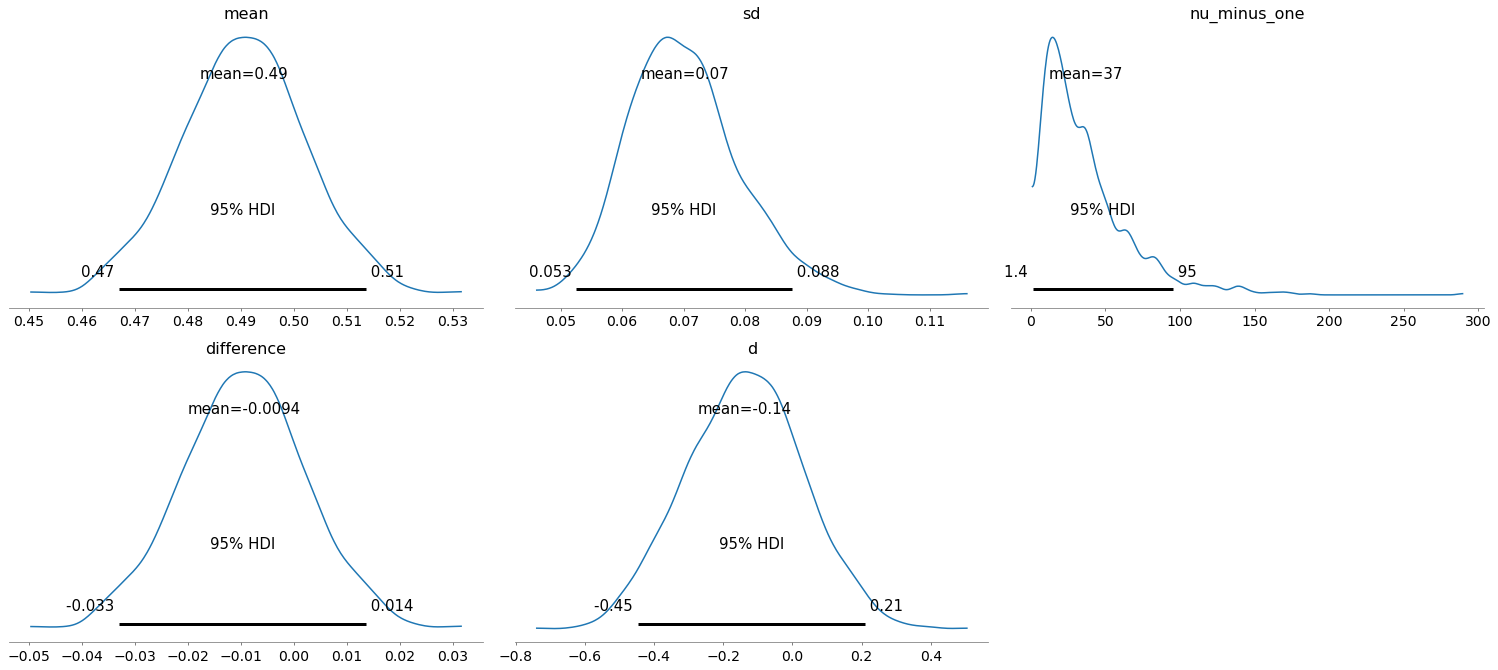

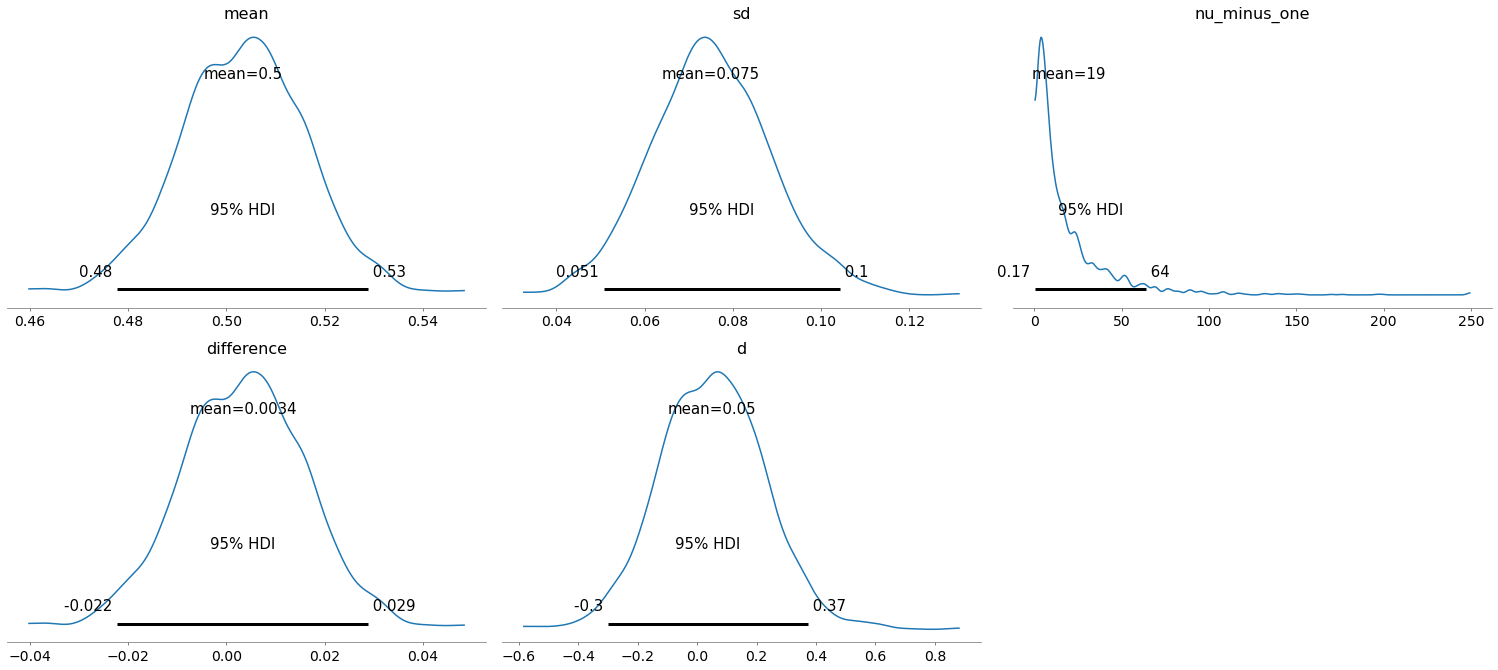

In [15]:
print("4. Running Bayesian t-test analysis of GLA-predicted RST vs. 0.5")
for e, effect in enumerate(["attraction", "compromise"]):
    print(f"\t{effect}")
    pred_gla = predicted.loc[predicted["model"] == "glickman1layer"]
    rst_pred = calc_rst(pred_gla, effect=effect)

    trace = best.runBEST1G(rst_pred, 0.5, sigma_low=0.0001)
    print(pm.summary(trace, hdi_prob=0.95))
    pm.plot_posterior(trace, hdi_prob=0.95)

While the GLA model predicts individual differences in RST, it does not predict any systematic context **on average across the group** (we observed a significant attraction effect, driven by strong responders, and a marginal compromise effect). This shows that it does not capture all features of context-dependency without additional modifications.